<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Image_Noise_Reduction_with_Auto_encoders-Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing the Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

In [3]:
# Data Processing

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalising the Data to be between 0 and 1
X_train = X_train.astype('float') / 255.
X_test = X_test.astype('float') / 255.

# Reshaping the Data
X_train = np.reshape(X_train, (60000, 784)) # Shape is (60000, 28, 28) -> We change to 60000, 784 | We unroll as Vector and Feed it to the Neural Networks
X_test = np.reshape(X_test, (10000, 784))

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# Adding Noise to Training and Test set Data
X_train_noisy = X_train + np.random.rand(60000, 784) * 0.8 # rand gives Random uniform value between 0 and 1
X_test_noisy = X_test + np.random.rand(10000, 784) * 0.8

# Clip them to value between 0 and 1 as the Noise may exceed 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [16]:
# Define a Function to plot the Images

def plot(x, p, labels= False): # X- Image, P - Prediction
    plt.figure(figsize= (20, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1) # 1 Row, 10 Column
        plt.imshow(x[i].reshape(28, 28), cmap= 'binary') # 28*28 reshape done, as we flattened the Image previously
        plt.xticks([]) # Removing X and Y ticks
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return

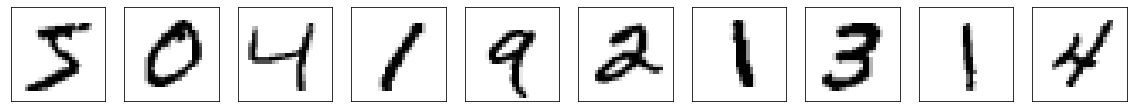

In [17]:
# Plot the X_Train 10 images
plot(X_train, None)

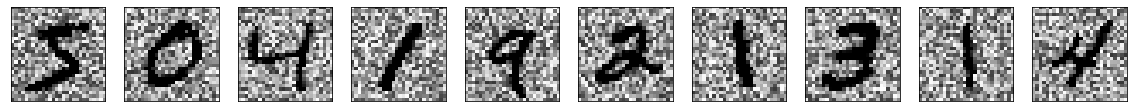

In [18]:
# Plot the Noisy X_Train 10 images
plot(X_train_noisy, None)

In [19]:
# Building and Training the Classifier

classifier = Sequential()
classifier.add(Dense(units= 256, activation= 'relu', input_shape= (784, )))
classifier.add(Dense(units= 256, activation= 'relu'))

# Output layer
classifier.add(Dense(units= 10, activation= 'softmax'))

# Compile and Summarize the model
classifier.compile(loss= "sparse_categorical_crossentropy", optimizer= "adam", metrics= ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Training the Model on Original Data

classifier.fit(X_train, y_train, epochs= 5, batch_size= 256)

Epoch 1/5
235/235 [==============================] - 2s 9ms/step - loss: 0.3272 - accuracy: 0.9079
Epoch 2/5
235/235 [==============================] - 2s 9ms/step - loss: 0.1197 - accuracy: 0.9642
Epoch 3/5
235/235 [==============================] - 2s 9ms/step - loss: 0.0784 - accuracy: 0.9760
Epoch 4/5
235/235 [==============================] - 2s 9ms/step - loss: 0.0566 - accuracy: 0.9830
Epoch 5/5
235/235 [==============================] - 2s 10ms/step - loss: 0.0412 - accuracy: 0.9876


In [21]:
# Train and Evaluate for Normal Image
loss, acc = classifier.evaluate(X_test, y_test)
print(f"The Model loss is {loss} and Accuracy is {acc}")

313/313 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9752
The Model loss is 0.0794159397482872 and Accuracy is 0.9751999974250793


In [22]:
# Train and Evaluate for Noisy Image

loss, acc = classifier.evaluate(X_test_noisy, y_test)
print(f"The Model loss is {loss} and Accuracy is {acc}")

313/313 [==============================] - 0s 1ms/step - loss: 7.0269 - accuracy: 0.2686
The Model loss is 7.026860237121582 and Accuracy is 0.2685999870300293


In [26]:
# Autoencoder building to Denoise the Data

input_image = Input(shape= (784,))
encoded = Dense(units= 128, activation= 'relu')(input_image) # Orig is 64
decoded = Dense(units= 784, activation= 'sigmoid')(encoded)

# Applying the Layers to the Model
model = Model(input_image, decoded)
model.compile(optimizer= 'adam', loss= 'binary_crossentropy') # binary crossentropy can be used
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Training the AutoEncoders

model.fit(X_train_noisy, X_train,
          epochs= 100,
          batch_size= 512,
          validation_split= 0.2,
          verbose= 1,
          callbacks= [
                      EarlyStopping(monitor= 'val_loss', patience= 5)#,
                      #LambdaCallback(on_epoch_end= lambda e,l : print("{:.3f}".format(l['val_loss']), end=' _ ') ) # Goes on in Single line until training is complete instead of New Line
          ])
print(' _ ')
print("The Training is Complete!")

Epoch 1/100
94/94 [==============================] - 2s 26ms/step - loss: 0.2962 - val_loss: 0.2374
Epoch 2/100
94/94 [==============================] - 2s 25ms/step - loss: 0.2119 - val_loss: 0.1896
Epoch 3/100
94/94 [==============================] - 2s 24ms/step - loss: 0.1775 - val_loss: 0.1670
Epoch 4/100
94/94 [==============================] - 2s 24ms/step - loss: 0.1585 - val_loss: 0.1509
Epoch 5/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1441 - val_loss: 0.1387
Epoch 6/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1334 - val_loss: 0.1296
Epoch 7/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1256 - val_loss: 0.1229
Epoch 8/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1195 - val_loss: 0.1176
Epoch 9/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1148 - val_loss: 0.1135
Epoch 10/100
94/94 [==============================] - 2s 25ms/step - loss: 0.1110 - val_loss: 0.1103

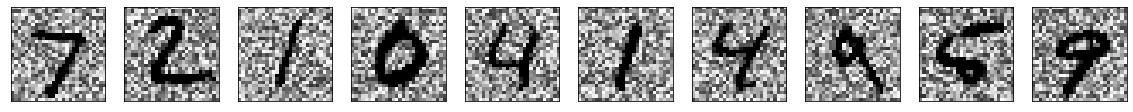

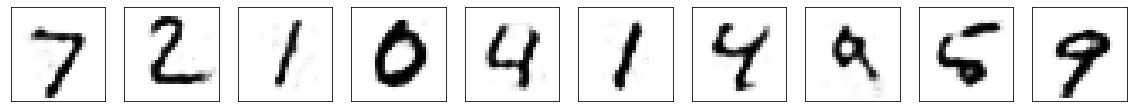

In [28]:
# Denoising the Images

predictions = model.predict(X_test_noisy)

# Plot the Prediction and Noisy one
plot(X_test_noisy, None)
plot(predictions, None)

In [29]:
# Predict via Classifier

loss, acc = classifier.evaluate(predictions, y_test)
print(f"The Model loss is {loss} and Accuracy is {acc}")

313/313 [==============================] - 0s 1ms/step - loss: 0.1105 - accuracy: 0.9650
The Model loss is 0.1104605495929718 and Accuracy is 0.9649999737739563


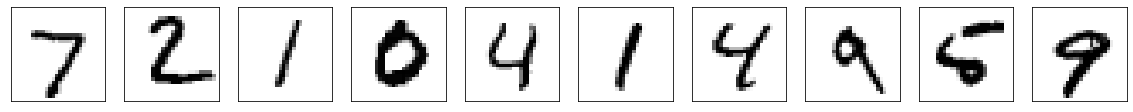

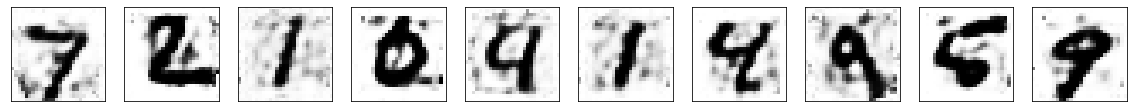

In [30]:
# Denoising the Images

predictions_nonoise = model.predict(X_test)

# Plot the Prediction and Noisy one
plot(X_test, None)
plot(predictions_nonoise, None)

In [31]:
# Predict via Classifier

loss, acc = classifier.evaluate(predictions_nonoise, y_test)
print(f"The Model loss is {loss} and Accuracy is {acc}")

313/313 [==============================] - 0s 1ms/step - loss: 2.0440 - accuracy: 0.6358
The Model loss is 2.043992280960083 and Accuracy is 0.6358000040054321


In [32]:
# If we pass on Non Noise data to AutoEncoder, it predicts okayish, but it is able to denoise the Noise data well and give great predictions. To Improve, we can use CNN in Autoencoder Model

# Composite Model

# Model Architecture
input_image = Input(shape= (784, ))
X = model(input_image)
y = classifier(X)

# Model
denoise_and_classify = Model(input_image, y)

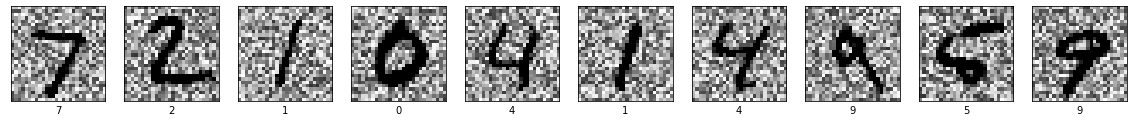

In [34]:
# Predictions
predictions = denoise_and_classify.predict(X_test_noisy)
plot(X_test_noisy, predictions, labels= True)